## Big Data in Finance Group Assignment 2

### Foreign Exchange Predictive Model

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import linear_model, ensemble, svm, neighbors, tree
from sklearn.model_selection import GridSearchCV

%matplotlib inline

#### Read Data

In [2]:
fxSpot = pd.read_excel('FX.xlsx', sheetname = 'FX_Spot', index_col = 'Date')
eurDep = pd.read_excel('FX.xlsx', sheetname = 'EuroDep', index_col = 'Date')
mSupply = pd.read_excel('FX.xlsx', sheetname = 'MoneySupply', index_col = 'Date')
indPrd = pd.read_excel('FX.xlsx', sheetname = 'IndProduction', index_col = 'Date')
cpi = pd.read_excel('FX.xlsx', sheetname = 'CPI', index_col = 'Date')

#### Variable Construction

In [3]:
# Y variable for all currencies
spotDelta_Matrix = np.diff(np.log(fxSpot.as_matrix()), axis = 0)
spotDelta_Matrix = np.insert(spotDelta_Matrix, 0, np.nan, axis = 0)
fxSpotDelta = pd.DataFrame(spotDelta_Matrix, index = fxSpot.index, columns = fxSpot.columns)

# X1 variable
intUSD = eurDep['USD'].as_matrix()
intDiff_Matrix = (eurDep.as_matrix().transpose() - intUSD).transpose()
intDiff = pd.DataFrame(intDiff_Matrix, index = eurDep.index, columns = eurDep.columns)

# X2 variable
inflDelta_Matrix = np.diff(np.log(cpi.as_matrix()), axis = 0)
inflDelta_Matrix = np.insert(inflDelta_Matrix, 0, np.nan, axis = 0)
inflDelta_US = inflDelta_Matrix[ : , inflDelta_Matrix.shape[1] - 1]
inflDiff_Matrix = (inflDelta_Matrix.transpose() - inflDelta_US).transpose()
inflDiff = pd.DataFrame(inflDiff_Matrix, index = cpi.index, columns = cpi.columns)

# X3 variable
indPrd_logMatrix = np.log(indPrd.as_matrix())
indPrd_logUS = indPrd_logMatrix[ : , indPrd_logMatrix.shape[1] - 1]
indPrdDiff_Matrix = (indPrd_logMatrix.transpose() - indPrd_logUS).transpose()
indPrdDiff = pd.DataFrame(indPrdDiff_Matrix, index = indPrd.index, columns = indPrd.columns)

# X4 variable
mSupply_logMatrix = np.log(mSupply.as_matrix())
mSupply_logUS = mSupply_logMatrix[ : , mSupply_logMatrix.shape[1] - 1]
mSupplyDiff_Matrix = (mSupply_logMatrix.transpose() - mSupply_logUS).transpose()
mSupplyDiff = pd.DataFrame(mSupplyDiff_Matrix, index = mSupply.index, columns = mSupply.columns)

In [16]:
def calcMaxDrawDown(cumDiffCurr):
    maxDrawDown = 0
    maxPoint = cumDiffCurr[0]
    for i in range(1, len(cumDiffCurr)):
        if (maxPoint - cumDiffCurr[i]) > maxDrawDown:
            maxDrawDown = (maxPoint - cumDiffCurr[i])
        if cumDiffCurr[i] > maxPoint:
            maxPoint = cumDiffCurr[i]
    return maxDrawDown

#### Rolling Window Method and Plot

In [4]:
def learnAndPlot(windowSize, model, fxSpotDelta, intDiff, inflDiff, indPrdDiff, mSupplyDiff):
    # Windows Size
    w = windowSize

    # Random Forest Param Grid
    #param_grid = {"min_samples_leaf": [1, 3, 10]}

    cumDiffList = [] # Cumulative RMSE difference between prediction model and historical mean
    RsqrOOSList = [] # Final R-Square OOS for different currencies
    for currency in fxSpotDelta.columns.values:
        print("Currency = ", currency)
        histMeanMSE = []
        modelMSE = []
        for yIdx in range(2, fxSpotDelta.shape[0] - w): # First y(i+1) ranges from 3 to 384
            #print("yIdx = ", yIdx)
            xIdx = yIdx - 1
            yMat = fxSpotDelta[currency].as_matrix()
            x1Mat = intDiff[currency].as_matrix()
            x2Mat = inflDiff[currency].as_matrix()
            x3Mat = indPrdDiff[currency].as_matrix()
            x4Mat = mSupplyDiff[currency].as_matrix()
            Y = yMat[yIdx:(yIdx + w)]
            X1 = x1Mat[xIdx:(xIdx + w)]
            X2 = x2Mat[xIdx:(xIdx + w)]
            X3 = x3Mat[xIdx:(xIdx + w)]
            X4 = x4Mat[xIdx:(xIdx + w)]
            X = np.vstack((X1, X2, X3, X4)).T
            # Linear Regression Model
            #model = linear_model.LinearRegression()
            # LASSO with 10-fold cross validation to select the best alpha
            #model = linear_model.LassoCV(cv = 10)
            # Random Forest without Cross Validation
            #model = ensemble.RandomForestRegressor(n_estimators = 20)
            # Random Forest with Grid Search CV
            #model = GridSearchCV(ensemble.RandomForestRegressor(n_estimators = 20), param_grid = param_grid, cv = 10)
            model.fit(X, Y)
            PredX = np.array([[x1Mat[xIdx + w], x2Mat[xIdx + w], x3Mat[xIdx + w], x4Mat[xIdx + w]]])
            YhistPred = np.mean(Y)
            YModelPred = model.predict(PredX)
            actY = yMat[yIdx + w]
            histMeanMSE.append((YhistPred - actY)**2)
            modelMSE.append((YModelPred[0] - actY)**2)

        # RMSE
        histMeanRMSE = np.sqrt(np.array(histMeanMSE))
        modelRMSE= np.sqrt(np.array(modelMSE))
        diffRMSE = histMeanRMSE - modelRMSE
        # R-Square OOS
        RsqrOOS = 1 - (np.sum(np.array(modelMSE)) / np.sum(np.array(histMeanMSE)))

        cumDiffList.append(np.insert(diffRMSE.cumsum(), 0, np.zeros(2 + w)))
        RsqrOOSList.append(RsqrOOS)

    cumDiff = np.array(cumDiffList).transpose()
    RsqrOOSAll = np.array(RsqrOOSList)
    
    plt.figure(figsize = (10, 6))
    datesList = [datetime.strptime(str(date), '%Y%m').date() for date in fxSpotDelta.index.values]
    for i in range(cumDiff.shape[1]):
        plt.plot(datesList, cumDiff[:, i], label = fxSpotDelta.columns.values[i])
    plt.axhline(0, color = 'grey', ls = 'dashed')
    plt.legend(loc = 'lower left')
    plt.title("Cumulative RMSE Difference vs Month")
    plt.xlabel("Month")
    plt.ylabel("Cumulative RMSE Difference")
    plt.show()
    plt.close()
    
    return cumDiff, RsqrOOSAll

#### Learn With Linear Regression

Currency =  AUD
Currency =  CAD
Currency =  CHF
Currency =  EUR
Currency =  GBP
Currency =  JPY
Currency =  NOK
Currency =  NZD
Currency =  SEK


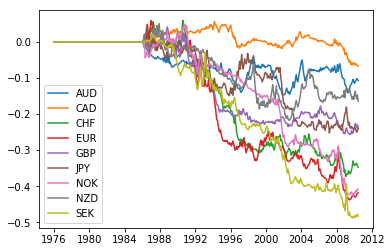

In [5]:
w = 120

# Linear Regression
linRegrCumDiff, linRegrRsqOOS = learnAndPlot(w, linear_model.LinearRegression(), fxSpotDelta, intDiff, inflDiff, indPrdDiff, 
                                             mSupplyDiff)

In [30]:
for i in range(linRegrCumDiff.shape[1]):
    print("Max DrawDown of ", fxSpotDelta.columns.values[i], ":", calcMaxDrawDown(linRegrCumDiff[ : , i]))

Max DrawDown of  AUD : 0.146933487385
Max DrawDown of  CAD : 0.124419382867
Max DrawDown of  CHF : 0.433127738837
Max DrawDown of  EUR : 0.497336958925
Max DrawDown of  GBP : 0.29879763387
Max DrawDown of  JPY : 0.292171583039
Max DrawDown of  NOK : 0.474020071191
Max DrawDown of  NZD : 0.26770128759
Max DrawDown of  SEK : 0.509215943017


#### Learn With LASSO Regression

Currency =  AUD
Currency =  CAD
Currency =  CHF
Currency =  EUR
Currency =  GBP
Currency =  JPY
Currency =  NOK
Currency =  NZD
Currency =  SEK


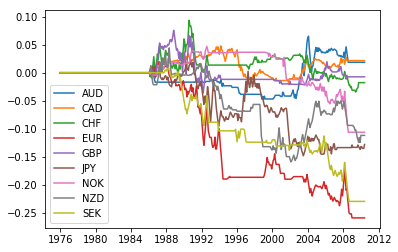

In [6]:
# LASSO Regression with alphas selected by 10-fold Cross Validation
lassoCumDiff, lassoRsqOOS = learnAndPlot(w, linear_model.LassoCV(cv = 10), fxSpotDelta, intDiff, inflDiff, indPrdDiff, 
                                         mSupplyDiff)

In [31]:
for i in range(lassoCumDiff.shape[1]):
    print("Max DrawDown of ", fxSpotDelta.columns.values[i], ":", calcMaxDrawDown(lassoCumDiff[ : , i]))

Max DrawDown of  AUD : 0.0635869213547
Max DrawDown of  CAD : 0.0661013366674
Max DrawDown of  CHF : 0.128068074794
Max DrawDown of  EUR : 0.278738401241
Max DrawDown of  GBP : 0.111927352225
Max DrawDown of  JPY : 0.170656386601
Max DrawDown of  NOK : 0.15321665552
Max DrawDown of  NZD : 0.203297504957
Max DrawDown of  SEK : 0.238226416122


#### Learn With Random Forest Regression

Currency =  AUD
Currency =  CAD
Currency =  CHF
Currency =  EUR
Currency =  GBP
Currency =  JPY
Currency =  NOK
Currency =  NZD
Currency =  SEK


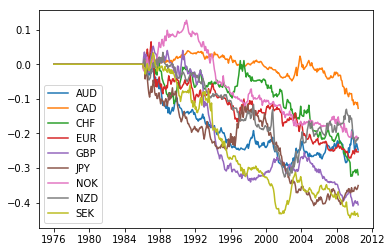

In [7]:
# Random Forest Regression with min_samples_leaf selected by 10-fold Cross Validation
param_grid = {"min_samples_leaf": [1, 3, 10]}
rfCumDiff, rfRsqOOS = learnAndPlot(w, GridSearchCV(ensemble.RandomForestRegressor(n_estimators = 20), param_grid = param_grid, 
                                                   cv = 10), 
                                   fxSpotDelta, intDiff, inflDiff, indPrdDiff, mSupplyDiff)

In [32]:
for i in range(rfCumDiff.shape[1]):
    print("Max DrawDown of ", fxSpotDelta.columns.values[i], ":", calcMaxDrawDown(rfCumDiff[ : , i]))

Max DrawDown of  AUD : 0.311843259423
Max DrawDown of  CAD : 0.166337903685
Max DrawDown of  CHF : 0.358569417361
Max DrawDown of  EUR : 0.335887650707
Max DrawDown of  GBP : 0.461948189533
Max DrawDown of  JPY : 0.410221324683
Max DrawDown of  NOK : 0.342958587311
Max DrawDown of  NZD : 0.360175444214
Max DrawDown of  SEK : 0.476632928097


#### Learn With Elastic Net

Currency =  AUD
Currency =  CAD
Currency =  CHF
Currency =  EUR
Currency =  GBP
Currency =  JPY
Currency =  NOK
Currency =  NZD
Currency =  SEK


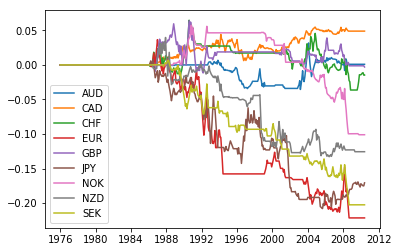

In [8]:
# Elastic Net
ecCumDiff, ecRsqOOS = learnAndPlot(w, linear_model.ElasticNetCV(l1_ratio = [.1, .5, .7, .9, .95, .99, 1], normalize = True, 
                                                                cv = 10), 
                                   fxSpotDelta, intDiff, inflDiff, indPrdDiff, mSupplyDiff)

In [33]:
for i in range(ecCumDiff.shape[1]):
    print("Max DrawDown of ", fxSpotDelta.columns.values[i], ":", calcMaxDrawDown(ecCumDiff[ : , i]))

print("R square OOS: ", np.mean(ecRsqOOS))

Max DrawDown of  AUD : 0.0486840004381
Max DrawDown of  CAD : 0.0379382492908
Max DrawDown of  CHF : 0.100986573956
Max DrawDown of  EUR : 0.257997912043
Max DrawDown of  GBP : 0.0757061813121
Max DrawDown of  JPY : 0.215792956576
Max DrawDown of  NOK : 0.158610766572
Max DrawDown of  NZD : 0.172539030627
Max DrawDown of  SEK : 0.208968459528
R square OOS:  -0.0259607815428


#### Learn With SVM Regression

Currency =  AUD
Currency =  CAD
Currency =  CHF
Currency =  EUR
Currency =  GBP
Currency =  JPY
Currency =  NOK
Currency =  NZD
Currency =  SEK


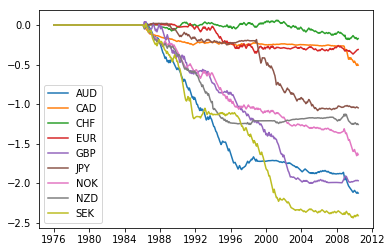

In [9]:
# SVM Regression with kernels selected by 10-fold Cross Validation
param_grid = {"kernel": ['linear', 'rbf', 'sigmoid']}
svrCumDiff, svrRsqOOS = learnAndPlot(w, GridSearchCV(svm.SVR(), param_grid = param_grid, cv = 10), 
                                     fxSpotDelta, intDiff, inflDiff, indPrdDiff, mSupplyDiff)

In [34]:
for i in range(svrCumDiff.shape[1]):
    print("Max DrawDown of ", fxSpotDelta.columns.values[i], ":", calcMaxDrawDown(svrCumDiff[ : , i]))

Max DrawDown of  AUD : 2.15170583298
Max DrawDown of  CAD : 0.510914653432
Max DrawDown of  CHF : 0.243752021715
Max DrawDown of  EUR : 0.386602801666
Max DrawDown of  GBP : 2.04370117019
Max DrawDown of  JPY : 1.10357689896
Max DrawDown of  NOK : 1.65368479048
Max DrawDown of  NZD : 1.25845293066
Max DrawDown of  SEK : 2.45823768741


#### Learn With kNN Regression

Currency =  AUD
Currency =  CAD
Currency =  CHF
Currency =  EUR
Currency =  GBP
Currency =  JPY
Currency =  NOK
Currency =  NZD
Currency =  SEK


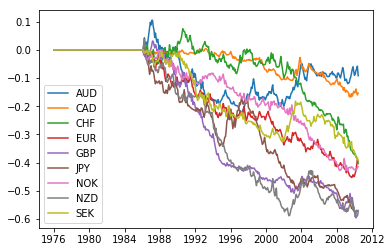

In [10]:
# kNN Regression with K selected by 10-fold Cross Validation
param_grid = {"n_neighbors": [1, 5, 9]}
knnCumDiff, knnRsqOOS = learnAndPlot(w, GridSearchCV(neighbors.KNeighborsRegressor(), param_grid = param_grid, cv = 10), 
                                     fxSpotDelta, intDiff, inflDiff, indPrdDiff, mSupplyDiff)

In [35]:
for i in range(knnCumDiff.shape[1]):
    print("Max DrawDown of ", fxSpotDelta.columns.values[i], ":", calcMaxDrawDown(knnCumDiff[ : , i]))

Max DrawDown of  AUD : 0.325618636996
Max DrawDown of  CAD : 0.172362903994
Max DrawDown of  CHF : 0.479276654951
Max DrawDown of  EUR : 0.453149377855
Max DrawDown of  GBP : 0.628345841049
Max DrawDown of  JPY : 0.596252017137
Max DrawDown of  NOK : 0.430724556407
Max DrawDown of  NZD : 0.631112676076
Max DrawDown of  SEK : 0.393631993919


#### Learn With Regression Tree

Currency =  AUD
Currency =  CAD
Currency =  CHF
Currency =  EUR
Currency =  GBP
Currency =  JPY
Currency =  NOK
Currency =  NZD
Currency =  SEK


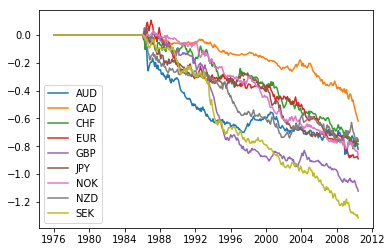

In [11]:
# Tree Regression with "min samples leaf" selected by 10-fold Cross Validation
param_grid = {"min_samples_leaf": [1, 3, 10]}
treeCumDiff, treeRsqOOS = learnAndPlot(w, GridSearchCV(tree.DecisionTreeRegressor(), param_grid = param_grid, cv = 10), 
                                       fxSpotDelta, intDiff, inflDiff, indPrdDiff, mSupplyDiff)

In [36]:
for i in range(treeCumDiff.shape[1]):
    print("Max DrawDown of ", fxSpotDelta.columns.values[i], ":", calcMaxDrawDown(treeCumDiff[ : , i]))

Max DrawDown of  AUD : 0.858216462091
Max DrawDown of  CAD : 0.618212531242
Max DrawDown of  CHF : 0.822495449433
Max DrawDown of  EUR : 0.997135508086
Max DrawDown of  GBP : 1.17497065952
Max DrawDown of  JPY : 0.836617520306
Max DrawDown of  NOK : 0.891950145236
Max DrawDown of  NZD : 0.765269178771
Max DrawDown of  SEK : 1.31613969462


#### Learn With LASSO Selected Attributes

In [24]:
def learnAndPlot2(windowSize, model, fxSpotDelta, intDiff, inflDiff, indPrdDiff, mSupplyDiff):
    # Windows Size
    w = windowSize

    # Random Forest Param Grid
    #param_grid = {"min_samples_leaf": [1, 3, 10]}

    cumDiffList = [] # Cumulative RMSE difference between prediction model and historical mean
    RsqrOOSList = [] # Final R-Square OOS for different currencies
    for currency in fxSpotDelta.columns.values:
        print("Currency = ", currency)
        histMeanMSE = []
        modelMSE = []
        for yIdx in range(2, fxSpotDelta.shape[0] - w): # First y(i+1) ranges from 3 to 384
            #print("yIdx = ", yIdx)
            xIdx = yIdx - 1
            yMat = fxSpotDelta[currency].as_matrix()
            x1Mat = intDiff[currency].as_matrix()
            x2Mat = inflDiff[currency].as_matrix()
            x3Mat = indPrdDiff[currency].as_matrix()
            x4Mat = mSupplyDiff[currency].as_matrix()
            Y = yMat[yIdx:(yIdx + w)]
            X1 = x1Mat[xIdx:(xIdx + w)]
            X2 = x2Mat[xIdx:(xIdx + w)]
            X3 = x3Mat[xIdx:(xIdx + w)]
            X4 = x4Mat[xIdx:(xIdx + w)]
            X = np.vstack((X1, X2, X3, X4)).T
            
            # Historical Mean Calculation
            YhistPred = np.mean(Y)
            
            # Linear Regression Model
            #model = linear_model.LinearRegression()
            # LASSO with 10-fold cross validation to select the best alpha
            lassoModel = linear_model.LassoCV(cv = 10)
            lassoModel.fit(X, Y)
            idxAttrToUse = list(np.where(lassoModel.coef_ != 0)[0])
            if len(idxAttrToUse) == 0:
                YModelPred = YhistPred
            else:
                model.fit(X[ : , idxAttrToUse ], Y)
                PredX = np.array([[x1Mat[xIdx + w], x2Mat[xIdx + w], x3Mat[xIdx + w], x4Mat[xIdx + w]]])
                PredX = PredX[ : , idxAttrToUse ]
                YModelPred = model.predict(PredX)[0]
            # Random Forest without Cross Validation
            #model = ensemble.RandomForestRegressor(n_estimators = 20)
            # Random Forest with Grid Search CV
            #model = GridSearchCV(ensemble.RandomForestRegressor(n_estimators = 20), param_grid = param_grid, cv = 10)
            actY = yMat[yIdx + w]
            histMeanMSE.append((YhistPred - actY)**2)
            modelMSE.append((YModelPred - actY)**2)

        # RMSE
        histMeanRMSE = np.sqrt(np.array(histMeanMSE))
        modelRMSE= np.sqrt(np.array(modelMSE))
        diffRMSE = histMeanRMSE - modelRMSE
        # R-Square OOS
        RsqrOOS = 1 - (np.sum(np.array(modelMSE)) / np.sum(np.array(histMeanMSE)))

        cumDiffList.append(np.insert(diffRMSE.cumsum(), 0, np.zeros(2 + w)))
        RsqrOOSList.append(RsqrOOS)

    cumDiff = np.array(cumDiffList).transpose()
    RsqrOOSAll = np.array(RsqrOOSList)

    plt.figure(figsize = (10, 6))
    datesList = [datetime.strptime(str(date), '%Y%m').date() for date in fxSpotDelta.index.values]
    for i in range(cumDiff.shape[1]):
        plt.plot(datesList, cumDiff[:, i], label = fxSpotDelta.columns.values[i])
    plt.axhline(0, color = 'grey', ls = 'dashed')
    plt.title("Cumulative RMSE Difference vs Month")
    plt.xlabel("Month")
    plt.ylabel("Cumulative RMSE Difference")
    plt.legend(loc = 'lower left')
    plt.show()
    plt.close()
    
    return cumDiff, RsqrOOSAll

#### Learn With Elastic Net (LASSO-Selected Attributes)

Currency =  AUD
Currency =  CAD
Currency =  CHF
Currency =  EUR
Currency =  GBP
Currency =  JPY
Currency =  NOK
Currency =  NZD
Currency =  SEK


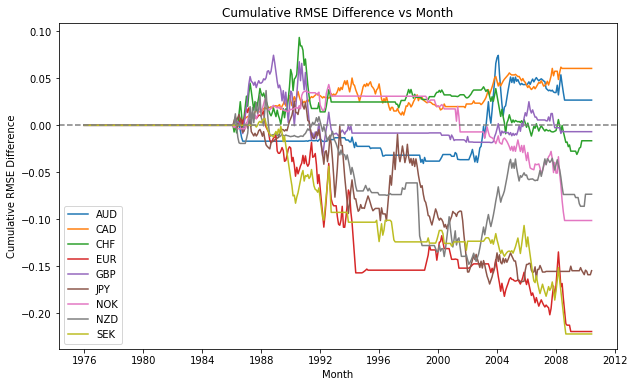

In [25]:
# Elastic Net with LASSO attributes
ecCumDiff2, ecRsqOOS2 = learnAndPlot2(w, linear_model.ElasticNetCV(l1_ratio = [.1, .5, .7, .9, .95, .99, 1], normalize = True, 
                                                                cv = 10), 
                                      fxSpotDelta, intDiff, inflDiff, indPrdDiff, mSupplyDiff)

In [28]:
for i in range(ecCumDiff2.shape[1]):
    print("Max DrawDown of ", fxSpotDelta.columns.values[i], ":", calcMaxDrawDown(ecCumDiff2[ : , i]))

print("R square OOS: ", np.mean(ecRsqOOS2))

Max DrawDown of  AUD : 0.064180761445
Max DrawDown of  CAD : 0.0394763759542
Max DrawDown of  CHF : 0.124525212933
Max DrawDown of  EUR : 0.238153716261
Max DrawDown of  GBP : 0.106942394182
Max DrawDown of  JPY : 0.196798358477
Max DrawDown of  NOK : 0.144802625268
Max DrawDown of  NZD : 0.184941327522
Max DrawDown of  SEK : 0.229401776282
R square OOS:  -0.0298419668892


#### Learn With Random Forest (LASSO-Selected Attributes)

Currency =  AUD
Currency =  CAD
Currency =  CHF
Currency =  EUR
Currency =  GBP
Currency =  JPY
Currency =  NOK
Currency =  NZD
Currency =  SEK


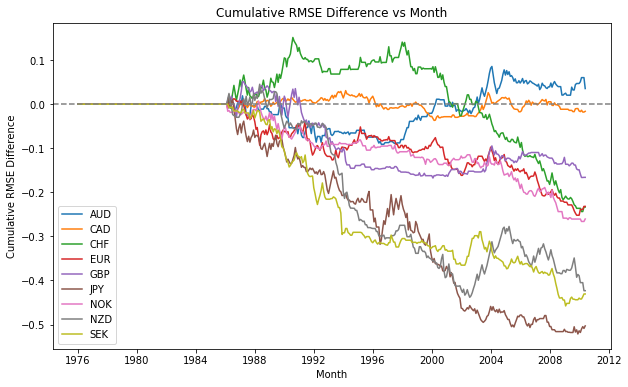

In [37]:
# Random Forest Regression with LASSO attributes
param_grid = {"min_samples_leaf": [1, 3, 10]}
rfCumDiff2, rfRsqOOS2 = learnAndPlot2(w, GridSearchCV(ensemble.RandomForestRegressor(n_estimators = 20), 
                                                      param_grid = param_grid, cv = 10), 
                                      fxSpotDelta, intDiff, inflDiff, indPrdDiff, mSupplyDiff)

In [38]:
for i in range(rfCumDiff2.shape[1]):
    print("Max DrawDown of ", fxSpotDelta.columns.values[i], ":", calcMaxDrawDown(rfCumDiff2[ : , i]))

Max DrawDown of  AUD : 0.110022202151
Max DrawDown of  CAD : 0.0676370195915
Max DrawDown of  CHF : 0.395062323342
Max DrawDown of  EUR : 0.264440323205
Max DrawDown of  GBP : 0.218583314095
Max DrawDown of  JPY : 0.542784882097
Max DrawDown of  NOK : 0.273303263664
Max DrawDown of  NZD : 0.483592523326
Max DrawDown of  SEK : 0.457768476658


#### Learn With SVM (LASSO-Selected Attributes)

Currency =  AUD
Currency =  CAD
Currency =  CHF
Currency =  EUR
Currency =  GBP
Currency =  JPY
Currency =  NOK
Currency =  NZD
Currency =  SEK


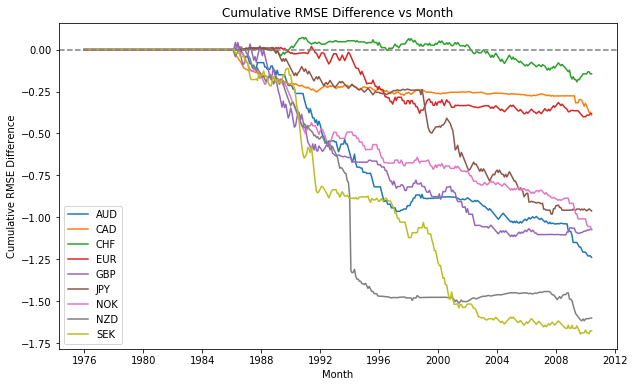

In [39]:
# SVM Regression with kernels selected by 10-fold Cross Validation
param_grid = {"kernel": ['linear', 'rbf', 'sigmoid']}
svrCumDiff2, svrRsqOOS2 = learnAndPlot2(w, GridSearchCV(svm.SVR(), param_grid = param_grid, cv = 10), 
                                        fxSpotDelta, intDiff, inflDiff, indPrdDiff, mSupplyDiff)

In [40]:
for i in range(svrCumDiff2.shape[1]):
    print("Max DrawDown of ", fxSpotDelta.columns.values[i], ":", calcMaxDrawDown(svrCumDiff2[ : , i]))

Max DrawDown of  AUD : 1.25686969044
Max DrawDown of  CAD : 0.390325871635
Max DrawDown of  CHF : 0.264527042578
Max DrawDown of  EUR : 0.419165447752
Max DrawDown of  GBP : 1.15737503465
Max DrawDown of  JPY : 0.993411226338
Max DrawDown of  NOK : 1.07511220293
Max DrawDown of  NZD : 1.63248095437
Max DrawDown of  SEK : 1.69566789815


#### Learn With kNN Regression (LASSO-Selected Attributes)

Currency =  AUD
Currency =  CAD
Currency =  CHF
Currency =  EUR
Currency =  GBP
Currency =  JPY
Currency =  NOK
Currency =  NZD
Currency =  SEK


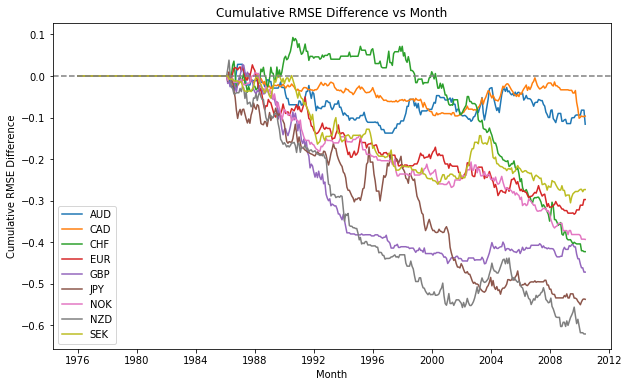

In [41]:
# kNN Regression with K selected by 10-fold Cross Validation
param_grid = {"n_neighbors": [1, 5, 9]}
knnCumDiff2, knnRsqOOS2 = learnAndPlot2(w, GridSearchCV(neighbors.KNeighborsRegressor(), param_grid = param_grid, cv = 10), 
                                        fxSpotDelta, intDiff, inflDiff, indPrdDiff, mSupplyDiff)

In [42]:
for i in range(knnCumDiff2.shape[1]):
    print("Max DrawDown of ", fxSpotDelta.columns.values[i], ":", calcMaxDrawDown(knnCumDiff2[ : , i]))

Max DrawDown of  AUD : 0.165495338252
Max DrawDown of  CAD : 0.107702692508
Max DrawDown of  CHF : 0.515153277111
Max DrawDown of  EUR : 0.359273775471
Max DrawDown of  GBP : 0.498815757607
Max DrawDown of  JPY : 0.556862455594
Max DrawDown of  NOK : 0.40044223647
Max DrawDown of  NZD : 0.658666851906
Max DrawDown of  SEK : 0.307122030057


#### Learn With Regression Tree (LASSO-Selected Attributes)

Currency =  AUD
Currency =  CAD
Currency =  CHF
Currency =  EUR
Currency =  GBP
Currency =  JPY
Currency =  NOK
Currency =  NZD
Currency =  SEK


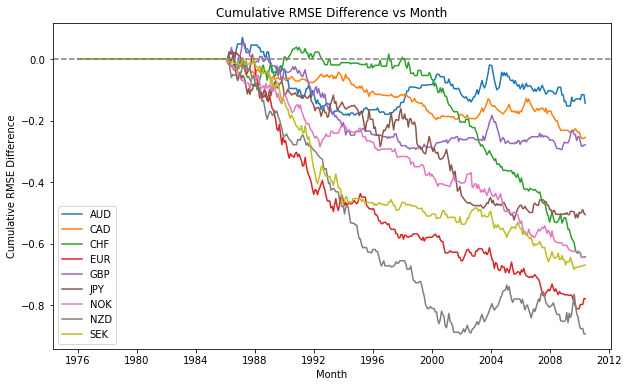

In [43]:
# Tree Regression with "min samples leaf" selected by 10-fold Cross Validation
param_grid = {"min_samples_leaf": [1, 3, 10]}
treeCumDiff2, treeRsqOOS2 = learnAndPlot2(w, GridSearchCV(tree.DecisionTreeRegressor(), param_grid = param_grid, cv = 10), 
                                          fxSpotDelta, intDiff, inflDiff, indPrdDiff, mSupplyDiff)

In [44]:
for i in range(treeCumDiff2.shape[1]):
    print("Max DrawDown of ", fxSpotDelta.columns.values[i], ":", calcMaxDrawDown(treeCumDiff2[ : , i]))

Max DrawDown of  AUD : 0.254261444395
Max DrawDown of  CAD : 0.258276600698
Max DrawDown of  CHF : 0.683155289845
Max DrawDown of  EUR : 0.832300654602
Max DrawDown of  GBP : 0.35020818121
Max DrawDown of  JPY : 0.548347849309
Max DrawDown of  NOK : 0.643874613757
Max DrawDown of  NZD : 0.893240388944
Max DrawDown of  SEK : 0.69085360505
